**Import Libraries**

In [125]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
nltk.download('punkt')
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# **1.Dataset Creation**

We aim to extract data from an XML file and save it in a properly structured CSV format. To achieve this, we utilized the ElementTree library for parsing and extracting data from the XML file. The extracted data is then stored in a file named dataset.csv.

In [126]:
#Parse the xml file
tree = ET.parse('/content/drive/MyDrive/New Stack Exchange/physics.stackexchange.com(1)/Posts.xml')
root = tree.getroot()

# define the columns of the dataset
columns = ['Id', 'PostTypeId', 'AcceptedAnswerId', 'Score', 'ViewCount', 'Tags', 'Title', 'Body', 'AnswerCount', 'CommentCount', 'FavoriteCount']

# create an empty list to store the data
data = []

for row in root.findall('.//row'):

  id_val = row.get('Id')
  post_type_id = row.get('PostTypeId')
  accepted_answer_id = row.get('AcceptedAnswerId')
  score = row.get('Score')
  Title = row.get('Title')
  view_count = row.get('ViewCount')
  Tags = row.get('Tags')
  body = row.get('Body')
  answer_count = row.get('AnswerCount')
  comment_count = row.get('CommentCount')
  favorite_count = row.get('FavoriteCount')

  # Append the attribute values as a list to the data list
  if int(post_type_id) == 1:
    data.append([id_val, post_type_id, accepted_answer_id, score, view_count, Tags, Title, body, answer_count, comment_count, favorite_count])


df = pd.DataFrame(data, columns=columns)

df.to_csv('dataset.csv', index=False)
print('dataset.csv created ')

dataset.csv created 


2. To handle the large size of the dataset, we are employing Simple Random Sampling to create a representative subset of the data.

In [127]:
df = pd.read_csv('dataset.csv', encoding='iso-8859-1')

# randomly sample 50000 rows from the dataframe
sample = df.sample(n=50000, replace=False, random_state=42)

sample.to_csv('sampled_dataset.csv')
print('sampled_dataset created')
print('Shape of dataset',sample.shape)

sampled_dataset created
Shape of dataset (50000, 11)


**3. Create complete dataset**

We need to generate dependent features based on the independent features and the answer count, applying specific conditions to define the relationships.

In [128]:
df = pd.read_csv('sampled_dataset.csv')

#create a new column that labels questions as 'good-quality', 'low quality', 'very-low quality'
def label_question(row):
  if row['Score'] > 5 and row['AnswerCount'] > 0:
    return 'good quality'
  elif row['Score'] <= 5 and row['Score'] >= 0 and row['AnswerCount'] >= 0:
    return 'low quality'
  elif row['Score'] < 0:
    return 'very low quality'
  else:
    return 'unknown'

df['question_quality'] = df.apply(label_question, axis=1)

# convert dataframe to csv file
df.to_csv("complete_dataset.csv")
print("complete_dataset created")

complete_dataset created


In [129]:
data = pd.read_csv('complete_dataset.csv')

# **2. Data Cleaning**

We are dropping irrelevant or unimportant columns that are not being used in the analysis. While columns like AnswerCount and Score were initially used to create dependent features, they are no longer needed and are therefore being removed.

In [130]:
col = ['Unnamed: 0', 'Unnamed: 0.1', 'Id', 'PostTypeId', 'AcceptedAnswerId', 'AnswerCount', 'Score']
data.drop(col, inplace=True, axis=1)

We are creating features for the length of the Title and Body data. Additionally, we are cleaning the Body text column by removing tags and unwanted characters.

In [131]:
# Remove <p> and </p> tags from the 'Body' column
data['Body'] = data['Body'].str.replace('<p>', '').str.replace('</p>', '')
data.head()

,ViewCount,Tags,Title,Body,CommentCount,FavoriteCount,question_quality
0,165,<electromagnetism><electromagnetic-induction>,What is doing work in eddy current braking?,Suppose we throw a metallic plate through the ...,0,NaN,low quality
1,15804,<newtonian-mechanics><classical-mechanics><flu...,Why is a beam reach the fastest point of sail ...,I've heard that a beam reach (perpendicular to...,4,5.0,good quality
2,965,<condensed-matter><solid-state-physics><diffra...,What does $d$-spacing between planes in a crys...,I have trouble understanding the meaning of $d...,1,NaN,low quality
3,110,<string-theory><topology><branes><calabi-yau>,D-brane wrapping in the geometric transition f...,"In Stefan Metzger's thesis (<a href=""https://a...",1,1.0,low quality
4,59,<homework-and-exercises><electromagnetism><mag...,Show $2(B \cdot \nabla)B = \nabla |B|^2$ when ...,I was able to show for myself that \n<span cla...,2,NaN,low quality


We are adding new features for the Title and Body columns, specifically the character count and word count for each.

In [132]:
#calculate the character count and word count for 'Title' column and 'Body' column
data['Title_Text_Length'] = data['Title'].str.len()

data['Body_Text_Length'] = data['Body'].str.len()

data['Body_Sentences_Count'] = data['Body'].apply(lambda x: len(str(x).split('.')) if isinstance(x, str) else 0)
data.head()

,ViewCount,Tags,Title,Body,CommentCount,FavoriteCount,question_quality,Title_Text_Length,Body_Text_Length,Body_Sentences_Count
0,165,<electromagnetism><electromagnetic-induction>,What is doing work in eddy current braking?,Suppose we throw a metallic plate through the ...,0,NaN,low quality,43,840,9
1,15804,<newtonian-mechanics><classical-mechanics><flu...,Why is a beam reach the fastest point of sail ...,I've heard that a beam reach (perpendicular to...,4,5.0,good quality,66,2139,12
2,965,<condensed-matter><solid-state-physics><diffra...,What does $d$-spacing between planes in a crys...,I have trouble understanding the meaning of $d...,1,NaN,low quality,63,445,4
3,110,<string-theory><topology><branes><calabi-yau>,D-brane wrapping in the geometric transition f...,"In Stefan Metzger's thesis (<a href=""https://a...",1,1.0,low quality,82,1477,11
4,59,<homework-and-exercises><electromagnetism><mag...,Show $2(B \cdot \nabla)B = \nabla |B|^2$ when ...,I was able to show for myself that \n<span cla...,2,NaN,low quality,95,628,8


In [133]:
df = data.copy()

We are dropping the Title and Body columns, as well as the Tags column. Upon evaluation, we found that the Tags column increases complexity without contributing to improved accuracy.

In [134]:
col = ['Title', 'Body', 'Tags']
data.drop(col, inplace=True, axis=1)

In [135]:
data.isnull().sum()

,0
ViewCount,0
CommentCount,0
FavoriteCount,29054
question_quality,0
Title_Text_Length,0
Body_Text_Length,0
Body_Sentences_Count,0


Since more than 50% of the data in the FavoriteCount column is null, we have decided to drop this column.

In [136]:
data.shape

(50000, 7)

In [137]:
data.drop('FavoriteCount', inplace=True, axis=1)
data.shape

(50000, 6)

**Check Duplicates**

In [138]:
data.duplicated().sum()

0

In [139]:
data.describe()

,ViewCount,CommentCount,Title_Text_Length,Body_Text_Length,Body_Sentences_Count
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000
mean,1328.180280,2.389200,57.130680,873.786940,8.21548
std,5967.521876,2.876333,24.526157,806.070576,8.07531
min,3.000000,0.000000,15.000000,32.000000,1.00000
25%,83.000000,0.000000,39.000000,372.000000,3.00000
50%,219.000000,2.000000,53.000000,650.000000,6.00000
75%,731.000000,3.000000,71.000000,1109.000000,11.00000
max,434533.000000,34.000000,163.000000,23809.000000,250.00000


Although outliers are present in the data, we are not removing them in this case. These outliers could represent high-quality questions with longer, well-explained text or, conversely, low-quality questions. Removing them might lead to the loss of valuable insights.

check data type of dataset

In [140]:
data.dtypes

,0
ViewCount,int64
CommentCount,int64
question_quality,object
Title_Text_Length,int64
Body_Text_Length,int64
Body_Sentences_Count,int64


The data type for the question_quality column should be set to "object," while all other columns should be of integer or float type.

In [141]:
data

,ViewCount,CommentCount,question_quality,Title_Text_Length,Body_Text_Length,Body_Sentences_Count
0,165,0,low quality,43,840,9
1,15804,4,good quality,66,2139,12
2,965,1,low quality,63,445,4
3,110,1,low quality,82,1477,11
4,59,2,low quality,95,628,8
...,...,...,...,...,...,...
49995,421,4,good quality,100,653,7
49996,392,0,low quality,121,1991,17
49997,279,5,low quality,81,717,1
49998,3091,1,good quality,41,504,3


# **3. Exploratory Data Analysis**

3.1 Observe dependent column

In [142]:
print('Dataset shape: ', data.shape)

Dataset shape:  (50000, 6)


In [143]:
data['question_quality'].value_counts()

,count
question_quality,
low quality,41422
good quality,5531
very low quality,2893
unknown,154


In [144]:
#percentage of class present in target variable(y)
print("percentage of low_quality, good_quality and very low quality \n", data['question_quality'].value_counts()/len(data)*100)

percentage of low_quality, good_quality and very low quality 
 question_quality
low quality         82.844
good quality        11.062
very low quality     5.786
unknown              0.308
Name: count, dtype: float64


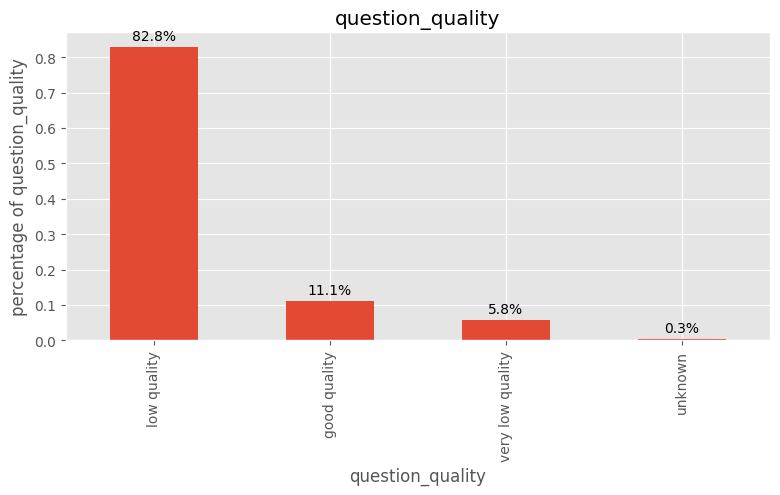

In [145]:
plt.style.use('ggplot')

plt.figure(figsize=(20,4))
ax = plt.subplot(121)
data['question_quality'].value_counts(normalize=True).plot(kind='bar')
plt.xlabel('question_quality')
plt.ylabel('percentage of question_quality')
plt.title('question_quality')

#Add percentage labels to the top of each bar
for p in ax.patches:
  ax.text(p.get_x()+p.get_width()/2., p.get_height()+0.02, f"{p.get_height()*100:.1f}%", ha="center")

The data in the question_quality column is imbalanced, with a distribution of 82.8% for one class, 11% for another, 5.8% for a third, and only 0.3% for the "unknown" category. Since the "unknown" data is minimal, we can either remove or replace it.

In [146]:
data = data[data['question_quality'] != 'unknown']

In [147]:
data.replace({'question_quality' : { 'very low quality' : 0, 'good quality' : 2, 'low quality' : 1 }},inplace=True)

<ipython-input-147-2e22b20a6400>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({'question_quality' : { 'very low quality' : 0, 'good quality' : 2, 'low quality' : 1 }},inplace=True)
<ipython-input-147-2e22b20a6400>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.replace({'question_quality' : { 'very low quality' : 0, 'good quality' : 2, 'low quality' : 1 }},inplace=True)


3.2 Univariate Analysis

<ipython-input-148-81e98e6c2049>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[column], kde=True, rug=True)
<ipython-input-148-81e98e6c2049>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[column], kde=True, rug=True)
<ipython-input-148-81e98e6c2049>:8: UserWarning: 

`distplot` is

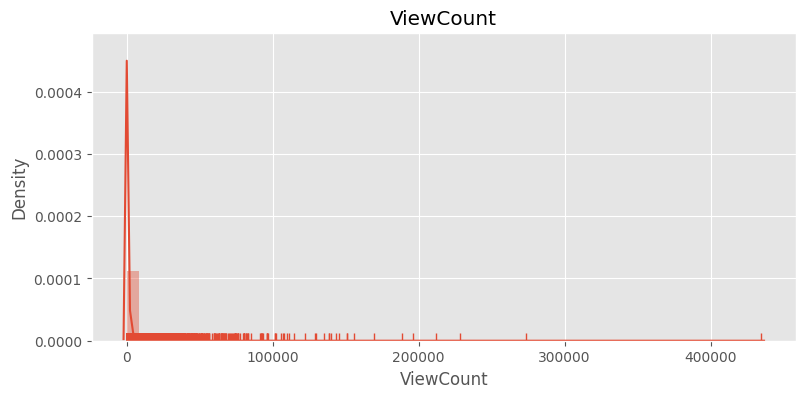

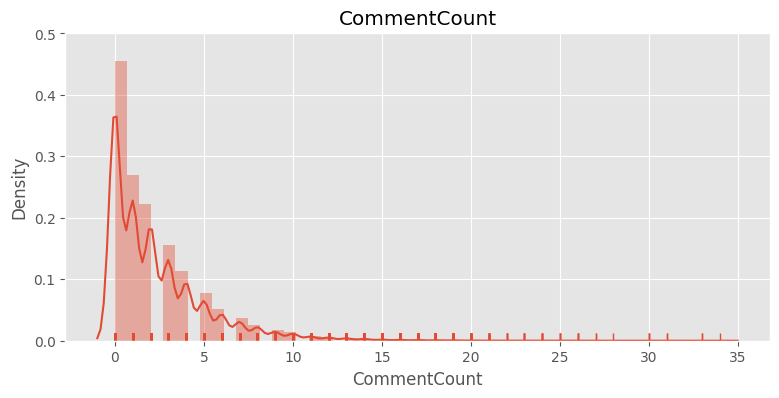

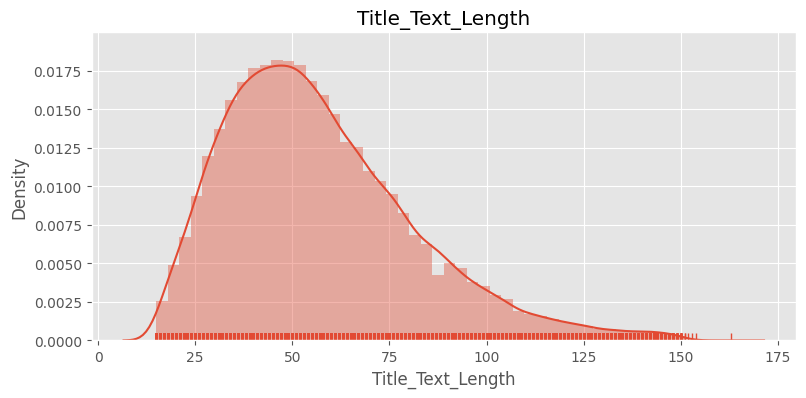

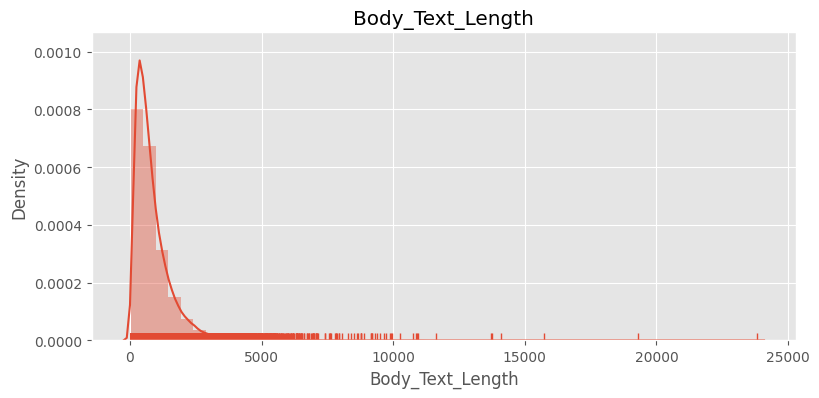

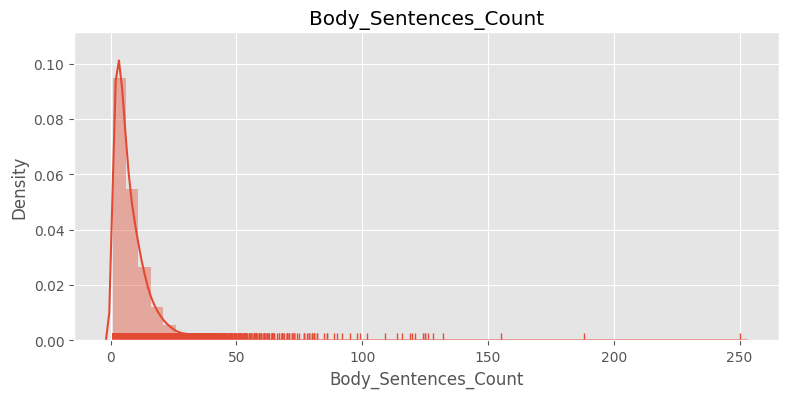

In [148]:
# plotting histogram for each numerical variable
column_names = list(data.columns)
column_names.remove('question_quality')
plt.style.use("ggplot")
for column in column_names:
    plt.figure(figsize=(20,4))
    plt.subplot(121)
    sns.distplot(data[column], kde=True, rug=True)
    plt.title(column)

Most of the columns exhibit skewed data, with the exception of Title_char_count and Title_word_count.

Since the outliers in this case are valuable, we cannot remove them, and thus, addressing skewness is not feasible.

3.3 correlation

<Axes: >

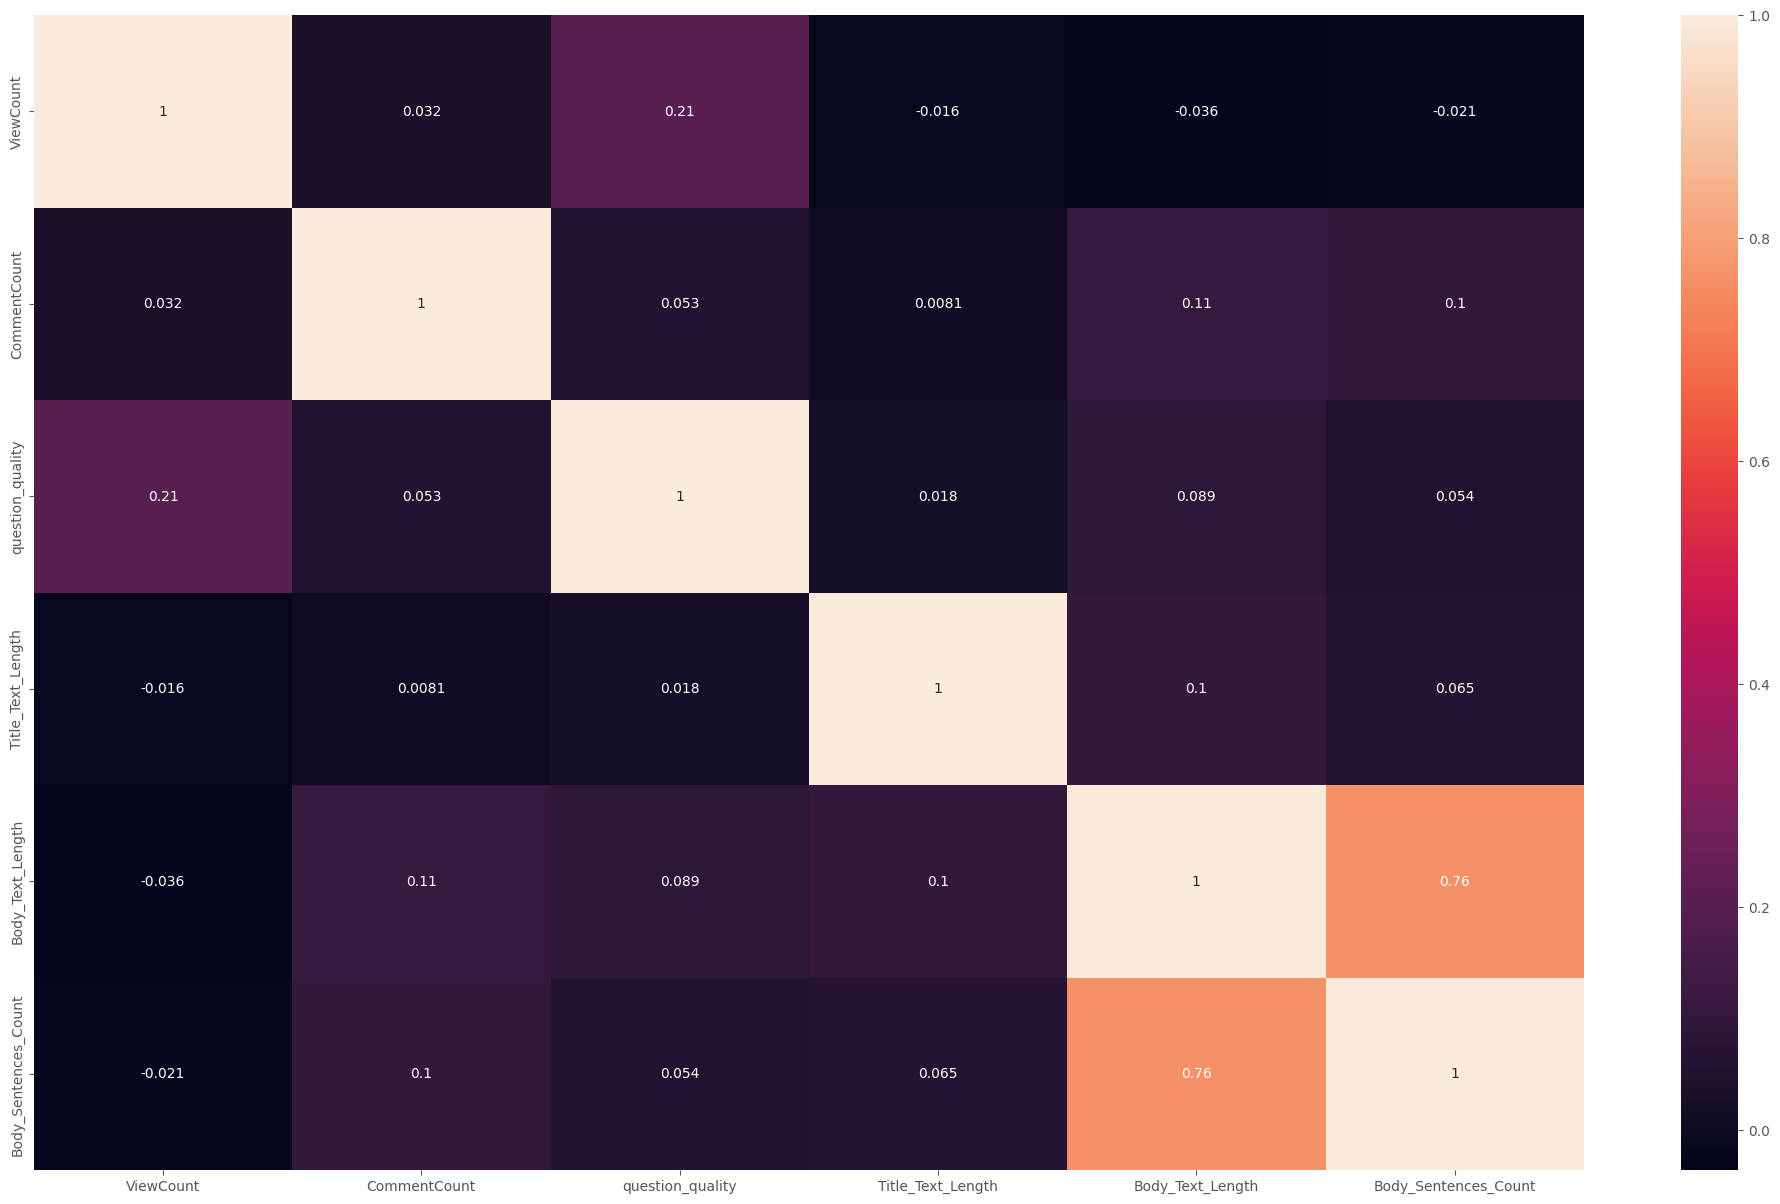

In [149]:
plt.figure(figsize=(25,15))
sns.heatmap(data.corr(), annot=True)

#**4. Split dataset into train and test**

In [151]:
X = data.drop(['question_quality'], axis=1)
y = data['question_quality']

'''from imblearn.over_sampling import SMOTENC

cat_features = np.array([0, 1, 2])
# Define the SMOTENC object with a sampling strategy for each class
sampling_strategy = {0: 20000, 1: 44000, 2: 20000}
smote_nc = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=cat_features, random_state=42)

# Apply SMOTE-NC oversampling to the training data
X_resampled, y_resampled = smote_nc.fit_resample(p, q)

# Check the class distribution of the resampled data
print(y_resampled.value_counts())'''

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# **5. Scaling**

In [152]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# **6.Model**

6.1 Logistic Regression

In [155]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

train_predicted = lr_model.predict(X_train)
test_predicted = lr_model.predict(X_test)

print("The accuracy of Logistic Regression on train data is: ", accuracy_score(y_train, train_predicted)*100, "%")
print("The accuracy of Logistic Regression on test data is: ", accuracy_score(y_test, test_predicted)*100, "%")

print("\nPrecision : ", precision_score(y_test, test_predicted, average='weighted'))
print("Recall : ",recall_score(y_test, test_predicted, average='weighted'))
print("F1-score : ", f1_score(y_test, test_predicted, average='weighted'))

The accuracy of Logistic Regression on train data is:  83.45310815666546 %
The accuracy of Logistic Regression on test data is:  83.5258358662614 %

Precision :  0.7661469260256334
Recall :  0.835258358662614
F1-score :  0.7729107354191166


These results show that the Logistic Regression model is performing consistently on both the training and test sets, achieving accuracies of around 83.5%. This indicates that the model is not overfitting to the training data and is generalizing well to new, unseen data.

6.2 RandomForestClassifier

In [156]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(X_train, y_train)
train_predicted = rf_model.predict(X_train)
test_predicted = rf_model.predict(X_test)

print("The accuracy of Random Forest on train data is : ", accuracy_score(y_train, train_predicted)*100, "%")
print("The accuracy of Random Forest on test data is : ", accuracy_score(y_test, test_predicted)*100, "%")

test_precision =  precision_score(y_test, test_predicted, average='weighted')
test_recall = recall_score(y_test, test_predicted, average='weighted')
test_f1 =  f1_score(y_test, test_predicted, average='weighted')

print("Precision (test): ", test_precision)
print("Recall (test): ", test_recall)
print("F1-score (test): ", test_f1)

The accuracy of Random Forest on train data is :  100.0 %
The accuracy of Random Forest on test data is :  83.12462006079028 %
Precision (test):  0.764288684177136
Recall (test):  0.8312462006079028
F1-score (test):  0.7838667416268802


In [157]:
importances = rf_model.feature_importances_
df1 = pd.DataFrame({"Features":pd.DataFrame(X_test).columns, "importances":importances})
df1.set_index("importances")

df1 = df1.sort_values('importances')

The results reveal that the Random Forest Classifier model achieves perfect precision, recall, and F1-score on the training set, but slightly lower performance on the test set. This suggests potential overfitting to the training data.

However, the precision, recall, and F1-score values on the test set are crucial for assessing the model's performance on new, unseen data. With an F1-score of 0.78 on the test set, the model demonstrates reasonable overall performance, though there is still room for improvement.

6.3 Cross validation

In [158]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Define the number of folds
n_folds = 3

# Define the multi-class classification model
model = RandomForestClassifier()

# Define the cross-validation model
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')

# Print the scores for each fold
print("Cross-validation scores:", scores)

# Calculate the mean and standard deviation of the scores
print("Mean accuracy:", np.mean(scores))
print("Standard deviation:", np.std(scores))


Cross-validation scores: [0.83088589 0.83153777 0.83207945]
Mean accuracy: 0.8315010354921634
Standard deviation: 0.0004879577840347175


In [159]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer

count_vec = CountVectorizer(max_features=10000)
bow = count_vec.fit_transform(df['Body'])
X = bow
y = df['question_quality']

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

#create an instance of the SMOTE class
smote = SMOTE()

#fit and apply smote to the training data only
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

#convert the resampled X_train to a dense numpy array
X_train_resampled = X_train_resampled.toarray()
#train your model on the resampled training data
model = MultinomialNB().fit(X_train_resampled, y_train_resampled)


#evaluate the model on test set

train_predicted = model.predict(X_train)
test_predicted = model.predict(X_test)
test_precision = precision_score(y_test, test_predicted, average='weighted')
test_recall = recall_score(y_test, test_predicted, average='weighted')
test_f1 = f1_score(y_test, test_predicted, average='weighted')

print("Precision (test): ", test_precision)
print("Recall (test): ", test_recall)
print("F1-score (test): ", test_f1)

Precision (test):  0.7307392568886496
Recall (test):  0.6954666666666667
F1-score (test):  0.7117202413327857


In [163]:
importances = rf_model.feature_importances_
# Ensure the number of columns in X_test matches the feature importances
if X_test.shape[1] == len(importances):
    df1 = pd.DataFrame({
        "Features": X_test.columns,
        "importances": importances
    })
    df1.set_index("Features", inplace=True)
    df1 = df1.sort_values('importances')
    df1.plot.bar(color='teal', title="Feature Importances", legend=False)
else:
    print("Mismatch between number of features in X_test and length of feature importances.")


Mismatch between number of features in X_test and length of feature importances.


Random Forest:

    Train Accuracy: 100%
    Test Accuracy: 83.12%
    Train Precision, Recall, and F1-score: 1.0, 1.0, 1.0
    Test Precision, Recall, and F1-score: 0.76, 0.83, 0.78

Logistic Regression:

    Train Accuracy: 83.45%
    Test Accuracy: 83.53%
    Train Precision, Recall, and F1-score: 0.76, 0.83, 0.77
    Test Precision, Recall, and F1-score: 0.77, 0.84, 0.77

Multinomial Naive Bayes with SMOTE:

    Test Accuracy: 70.87%
    Test Precision: 0.73
    Test Recall: 0.70
    Test F1-score: 0.72

Based on accuracy and F1-score, Random Forest and Logistic Regression outperform Multinomial Naive Bayes. Random Forest achieves the highest train accuracy and perfect precision, recall, and F1-scores on the training set, along with strong performance on the test set. Logistic Regression also performs well, with similar accuracy and F1-score, and its precision and recall on the test set surpass those of Random Forest.

**Feature Importance**

['ViewCount', 'CommentCount', 'question_quality', 'Title_Text_Length', 'Body_Text_Length', 'Body_Sentences_Count']


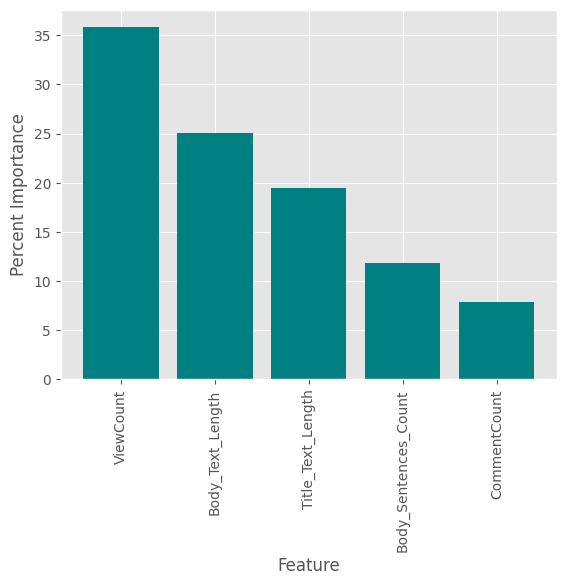

In [162]:
feature_names = list(data.columns)
print(feature_names)
if 'question_quality' in feature_names:
  feature_names.remove('question_quality')
total_importance = importances.sum()
percent_importances = importances / total_importance * 100

# Create a dataframe with the feature names and their percent importances
df = pd.DataFrame({"feature_names": feature_names, 'percent_importances' : percent_importances})

# Sort the dataframe by percent importances in descending order
df = df.sort_values(by='percent_importances', ascending=False)

# Create a bar plot of the percent importances
plt.bar(x=df['feature_names'], height=df['percent_importances'], color='teal')
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Percent Importance')
plt.show()

# **Conclusion**

Logistic regression is a widely used and effective classification algorithm, particularly suited for situations where there is a linear relationship between the input variables and the output. In this case, logistic regression achieved strong accuracy on both the training and test datasets, as well as solid performance in terms of precision, recall, and F1-score.

Moreover, logistic regression is a simple and interpretable model, which is advantageous when understanding the relationship between input variables and the output is crucial. It is also computationally efficient and can handle large datasets with ease.

Overall, logistic regression proved to be a strong choice for this problem, offering solid performance while maintaining simplicity and interpretability.